### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

### Loading and preparing the Dataset

In [4]:
df_medical = pd.read_csv("/content/data.csv")
df_medical.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
df_medical.shape

(4999, 6)

### Using Transcription column and keywords column

In [6]:
df_medical = df_medical.loc[:,["transcription", "keywords"]]
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4994,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


### Let us look at the nulls in the DataFrame

In [7]:
df_medical.isnull().sum()

transcription      33
keywords         1068
dtype: int64

### Removing Null values from the data

In [8]:
df_medical = df_medical[~(df_medical['transcription'].isnull()) &
                        ~(df_medical['keywords'].isnull()) ]

df_medical.shape

(3898, 2)

### Let us see the length of input and output

<ipython-input-9-8ab7d645bf90>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transcription)


<Axes: xlabel='transcription', ylabel='Density'>

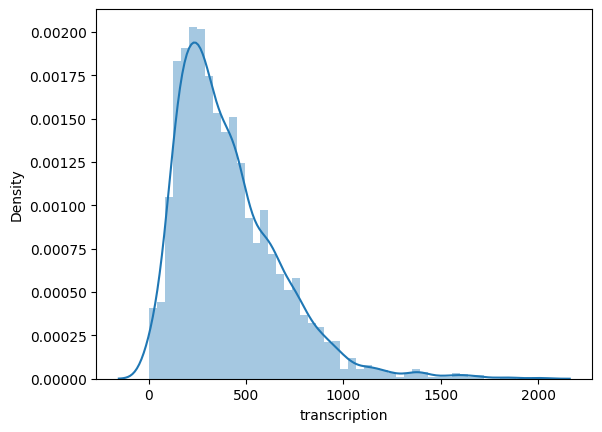

In [9]:
transcription = df_medical['transcription'].apply(lambda x: len(x.split()))
sns.distplot(transcription)

##### Fixing Input Length to 750 tokens with Padding and truncation

<ipython-input-10-4787efb74e39>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(keywords)


<Axes: xlabel='keywords', ylabel='Density'>

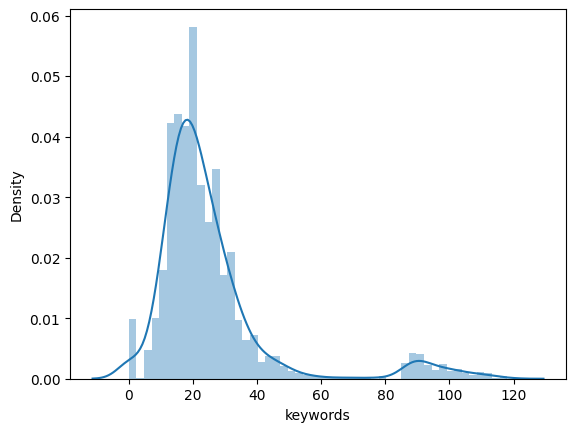

In [10]:
keywords = df_medical['keywords'].apply(lambda x: len(x.split()))

sns.distplot(keywords)

### Let us use at most 100 keywords

In [11]:
np.quantile(transcription,0.95)

894.0

In [12]:
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4984,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr..."
4985,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem..."
4989,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
4993,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."


In [13]:
!pip install accelerate bitsandbytes
from transformers import BartForConditionalGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", padding_side="left",
                                         truncation_side='right')

if torch.cuda.is_available():
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to("cuda")
                                                     # load_in_8bit=True)
else:
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 4.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

### For a pytorch model we need a DataLoader so implementing a Dataloader

In [14]:
class MedicalKeywordDataset(Dataset):
    def __init__(self, df, transcript, keywords, tokenizer, in_len, out_len):
        self.df = df
        self.transcript = transcript
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.in_len = in_len
        self.out_len = out_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        #print(self.df[self.transcript].iloc[idx])
        transcript_tokens = self.tokenizer(self.df[self.transcript].iloc[idx],
                                          padding='max_length',
                                          truncation=True,
                                          max_length=self.in_len,
                                          return_tensors='pt'
                                          )['input_ids']

        keyword_tokens = self.tokenizer(self.df[self.keywords].iloc[idx],
                                       padding="max_length", truncation=True,
                                       max_length=self.out_len,
                                       return_tensors='pt')['input_ids']

        ### Moving the tensors to GPU
        if torch.cuda.is_available():
            transcript_tokens = transcript_tokens.to("cuda")
            keyword_tokens = keyword_tokens.to("cuda")
        #print(transcript_tokens)
        return transcript_tokens[0,:], keyword_tokens[0,:]




from sklearn.model_selection import train_test_split

### Splitting the data to train and test sets
df_train, df_test = train_test_split(df_medical, train_size=0.9, random_state=34)


ds_train = MedicalKeywordDataset(df_train,'transcription','keywords',tokenizer,
                            750, 100)

ds_test = MedicalKeywordDataset(df_test,'transcription','keywords',tokenizer,
                            750, 100)


### Converting dataset object to dataloader object
batch_size = 6

### Conversion
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

### Now let us write the train and validation functions

In [15]:
### Optimizer Adam used here
optimizer = Adam(model.parameters(),lr=2e-4)

### Defining Epochs
epochs = 3

def num_batches(total, batch_size):
    if total % batch_size == 0:
        return total // batch_size
    else:
        return total // batch_size + 1


### Number of batches defined for a dataset
train_batches = num_batches(df_train.shape[0],batch_size)
test_batches = num_batches(df_test.shape[0],batch_size)


### Function to train model
def train(data,num_batches, model, optimizer):
    model.train()
    model_loss = 0
    model_acc = 0
    i = 0
    for tr, kw in data:
        optimizer.zero_grad()
        #print(kw.shape)
        ### Feed forward Pass
        out = model(tr, labels=kw)

        ### Loss computation
        r_loss = out.loss
        model_loss += r_loss.item()

        ### Accuracy Computation
        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(kw == preds).item()/(kw.shape[0]*kw.shape[1])
        model_acc += acc

        ### Backpropogation
        r_loss.backward()
        optimizer.step()

        i+=1
        print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\r")

    print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\n")


def test(data,num_batches, model):
    model.eval()
    model_loss = 0
    model_acc = 0
    i = 0
    for tr, kw in data:
        #optimzer.zero_grad()

        ### Feed forward Pass
        out = model(tr, labels=kw)

        ### Loss computation
        r_loss = out.loss
        model_loss += r_loss.item()

        ### Accuracy Computation
        logits = out.logits
        preds = torch.softmax(logits,dim=2)
        preds = torch.argmax(preds,dim=2)
        acc = torch.sum(kw == preds).item()/(kw.shape[0]*kw.shape[1])
        model_acc += acc

#         ### No Backpropogation as it is evaluation of model
#         r_loss.backward()
#         optimizer.step()

        i+=1
        print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\r")

    print("[" + "="*(50*i//num_batches) + ">" +
              " "*(50*(1 - i//num_batches))
              + "]" + f"loss={model_loss/i} accuracy={model_acc/i}",
              end="\n")

In [16]:
for e in range(epochs):
    train(dl_train,train_batches,model, optimizer)
    test(dl_test, test_batches,model)

[==================================================>]loss=1.2408575920467704 accuracy=0.7925683760683759
[==================================================>]loss=0.7896841489351712 accuracy=0.8410769230769228
[==================================================>]loss=0.7608721691319066 accuracy=0.8430541310541319
[==================================================>]loss=0.6799645254245171 accuracy=0.8542564102564102
[==================================================>]loss=0.6382354583495703 accuracy=0.8569629629629631
[==================================================>]loss=0.6207471563265874 accuracy=0.8633333333333333


In [17]:
df_medical

,transcription,keywords
0,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...
4984,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr..."
4985,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem..."
4989,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
4993,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."


### Let us compare the predictions from the test data

In [18]:
def generate_keywords(df,transcription, model, tokenizer):
    df['Result'] = df[transcription].apply(lambda x: tokenizer(x, max_length=750,
    padding='max_length', truncation=True, return_tensors='pt')['input_ids'])
    if torch.cuda.is_available():
        df['Result'] = df['Result'].apply(lambda x: x.to("cuda"))

    df['Result'] = df['Result'].apply(lambda x: model.generate(x,
                                                    min_length=20,
                                                    max_length=100 ))
    df['Result'] = df['Result'].apply(lambda x: tokenizer.batch_decode(x,
                                                    skip_special_tokens=True))
    return df




In [19]:
df_res = generate_keywords(df_test,'transcription',model,tokenizer)

KeyboardInterrupt: 

In [ ]:
model.generate(tokenizer(df_test['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True,
                        return_tensors='pt')['input_ids'].to('cuda'),max_length=100)

In [ ]:
tokenizer(df_test['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True)

In [ ]:
df_res['Result'] = df_res['Result'].apply(lambda x: x[0])

In [ ]:
print(df_res['keywords'].iloc[0])
print(df_res['Result'].iloc[0])

In [ ]:
df_res

### Looking at top 5

In [ ]:
for i in range(5):

    print(f"-----------------Row no {i+1}------------------")
    print("Transcription:")
    print(df_res['transcription'].iloc[i])
    print("\n")
    print("Keywords:")
    print(df_res['keywords'].iloc[i])
    print("\n")
    print("Result:")
    print(df_res['Result'].iloc[i])
    print("\n"*3)

### The first row is related to eyes the model predicts some keywrods on Eyes

### The Second row is related to `gynecology` as `endometriosis` is related to `gynecology` and some keywords like `deudenum` (the part of small intestine) is unrelated to gynaecology

### The third one is related to `genetilia` which corelates to human reproductive system

### The 4th one is clearly related to circulatory system from the words like `cardio`, `cardiovascular` `cardio pulmonary` and `bypass` etc

### The 5th one is related to bones `orthopedic` (bones) the words like `femur`, `fracture` confirms the same


### Conclusion:
1. BART Transformer model seems to perform well to extracting Medical keywords from transcription
2. There are some unrelated responses as we know AI can give misleading results so human knowledge and domain understanding is very important.
3. The model preformance can be imporved by having larger data corpus.
4. It can be trained on a large medical dataset and can be used ony any health care use case by fine-tuning it


In [32]:
dfm = pd.read_csv("/content/new_data.csv")

In [33]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [22]:
dfm= dfm.dropna(subset=["transcription"])

In [23]:
dfm.iloc[1068:1150]

,description,medical_specialty,sample_name,transcription,keywords
1068,MRI brain & Cerebral Angiogram: CNS Vasculiti...,Neurology,MRI Brain & Cerebral Angiogram,"CC:, Difficulty with word finding.,HX: ,This 2...",
1069,Distal metaphyseal osteotomy and bunionectomy...,Orthopedic,Osteotomy & Bunionectomy,"PREOPERATIVE DIAGNOSES:,1. Metatarsus primus ...",
1070,MRI Brain & MRI C-T spine: Multiple hemangiob...,Orthopedic,MRI Brain and C-T Spine,"CC:, Weakness.,HX:, This 30 y/o RHM was in goo...",
1071,"Arthroscopy, medial meniscoplasty, lateral me...",Orthopedic,Meniscoplasty & Chondroplasty,"PREOPERATIVE DIAGNOSIS:, Medial meniscal tear...",
1072,Diagnostic operative arthroscopy with repair ...,Orthopedic,Ligament Reconstruction & Meniscus Repair,"PREOPERATIVE DIAGNOSES:,1. Torn anterior cruc...",
...,...,...,...,...,...
1145,"Suspected mastoiditis ruled out, right acute ...",ENT - Otolaryngology,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",
1146,"Suspected mastoiditis ruled out, right acute ...",Emergency Room Reports,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",
1147,"Questionable foreign body, right nose. Belly...",Emergency Room Reports,Foreign Body - Right Nose,"CHIEF COMPLAINT:, Questionable foreign body, ...",
1148,"Nausea, vomiting, diarrhea, and fever.",General Medicine,Gen Med Consult - 27,"CHIEF COMPLAINT: , Nausea, vomiting, diarrhea,...",


In [30]:
dfm = dfm.loc[:,["transcription", "keywords"]]
dfm = dfm.iloc[:1065]
dfm


,transcription,keywords
0,"CC:, Confusion and slurred speech.,HX , (prima...",NaN
1,"CHIEF COMPLAINT:,",NaN
2,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...",NaN
3,"CHIEF COMPLAINT: , Right distal ureteral calcu...",NaN
4,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...",NaN
...,...,...
1060,"EXTERNAL EXAMINATION - SUMMARY,The body is pre...",NaN
1061,"EXTERNAL EXAMINATION: , The body is that of a ...",NaN
1062,"EXTERNAL EXAMINATION: , The autopsy is begun a...",NaN
1063,"FINAL DIAGNOSIS: ,I. Ligature strangulation.,A...",NaN


In [34]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [ ]:
df_res1 = generate_keywords(dfm,'transcription',model,tokenizer)
model.generate(tokenizer(dfm['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True,
                        return_tensors='pt')['input_ids'].to('cuda'),max_length=100)
tokenizer(dfm['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True)
df_res1['Result'] = df_res1['Result'].apply(lambda x: x[0])
print(df_res1['keywords'].iloc[0])
print(df_res1['Result'].iloc[0])
df_res1.to_csv("generated_csv.csv",index = False)

In [ ]:
df_res1

In [ ]:
len(dfm)

In [35]:
rows_in_df1 = 1149
rows_in_df2 = len(dfm) - rows_in_df1  # The remaining rows

# Split the original DataFrame into two DataFrames
df1 = dfm.head(rows_in_df1)
df2 = dfm.tail(rows_in_df2)

In [36]:
df1

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (prima...",NaN
1,Blood in urine - Transitional cell cancer of ...,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,",NaN
2,This is a 66-year-old male with signs and sym...,Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...",NaN
3,Right distal ureteral calculus. The patient ...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calcu...",NaN
4,The patient has a possibly torsion detorsion ...,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...",NaN
...,...,...,...,...,...
1144,Newly diagnosed cholangiocarcinoma. The pati...,Gastroenterology,Cholangiocarcinoma Consult,"REASON FOR CONSULTATION:, Newly diagnosed cho...",
1145,"Suspected mastoiditis ruled out, right acute ...",ENT - Otolaryngology,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",
1146,"Suspected mastoiditis ruled out, right acute ...",Emergency Room Reports,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",
1147,"Questionable foreign body, right nose. Belly...",Emergency Room Reports,Foreign Body - Right Nose,"CHIEF COMPLAINT:, Questionable foreign body, ...",


In [37]:
df2

,description,medical_specialty,sample_name,transcription,keywords
1149,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1150,"Chronic glossitis, xerostomia, probable envir...",Allergy / Immunology,Evaluation of Allergies,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."
1151,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
1152,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
1153,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 2,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
...,...,...,...,...,...
4994,Cystourethroscopy and tTransurethral resectio...,Urology,Cystourethroscopy & TURP - 1,"PREOPERATIVE DIAGNOSES:,1. Urinary retention....","urology, urinary retention, transurethral rese..."
4995,Recurrent urinary tract infection in a patien...,Urology,E. Coli UTI - Followup,"HISTORY OF PRESENT ILLNESS:, The patient pres...","urology, urinary tract infection, escherichia ..."
4996,Desire for sterility. Vasectomy. The vas wa...,Urology,Vasectomy - 3,"PREOPERATIVE DIAGNOSIS:, Desire for sterility...","urology, vas, contralateral, desire for steril..."
4997,Normal vasectomy,Urology,Vasectomy - 1,"DESCRIPTION:, The patient was placed in the s...","urology, vasectomy, allis clamp, catgut, hemoc..."


In [38]:
df_res1 = generate_keywords(df1,'transcription',model,tokenizer)
model.generate(tokenizer(df1['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True,
                        return_tensors='pt')['input_ids'].to('cuda'),max_length=100)
tokenizer(df1['transcription'].iloc[0],max_length=750,
                        padding="max_length", truncation=True)
df_res1['Result'] = df_res1['Result'].apply(lambda x: x[0])
print(df_res1['keywords'].iloc[0])
print(df_res1['Result'].iloc[0])
# df_res1.to_csv("generated_csv.csv",index = False)

<ipython-input-18-5debf4395445>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Result'] = df[transcription].apply(lambda x: tokenizer(x, max_length=750,
<ipython-input-18-5debf4395445>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Result'] = df['Result'].apply(lambda x: x.to("cuda"))
<ipython-input-18-5debf4395445>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

nan
neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,


In [39]:
df_res1

,description,medical_specialty,sample_name,transcription,keywords,Result
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (prima...",NaN,"neurology, ct brain, mri, moya moya, mci, brai..."
1,Blood in urine - Transitional cell cancer of ...,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,",NaN,"cardiovascular / pulmonary, progress note, che..."
2,This is a 66-year-old male with signs and sym...,Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...",NaN,"urology, urinary retention issues, cystoscopy,..."
3,Right distal ureteral calculus. The patient ...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calcu...",NaN,"hematology - oncology, laser lithotripsy, dist..."
4,The patient has a possibly torsion detorsion ...,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...",NaN,"pediatrics - neonatal, testicular pain, epidid..."
...,...,...,...,...,...,...
1144,Newly diagnosed cholangiocarcinoma. The pati...,Gastroenterology,Cholangiocarcinoma Consult,"REASON FOR CONSULTATION:, Newly diagnosed cho...",,"gastroenterology, cholangiocarcinoma, liver fu..."
1145,"Suspected mastoiditis ruled out, right acute ...",ENT - Otolaryngology,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",,"ent - otolaryngology, acute otitis media, mast..."
1146,"Suspected mastoiditis ruled out, right acute ...",Emergency Room Reports,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...",,"ent - otolaryngology, acute otitis media, mast..."
1147,"Questionable foreign body, right nose. Belly...",Emergency Room Reports,Foreign Body - Right Nose,"CHIEF COMPLAINT:, Questionable foreign body, ...",,"ent - otolaryngology, belly, back pain, foreig..."


In [41]:
df_res1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1149 non-null   object
 1   medical_specialty  1149 non-null   object
 2   sample_name        1149 non-null   object
 3   transcription      1149 non-null   object
 4   keywords           81 non-null     object
 5   Result             1149 non-null   object
dtypes: object(6)
memory usage: 54.0+ KB


In [43]:
df_res1.drop("keywords",axis = 1,inplace = True)

<ipython-input-43-7f5e2d9e5344>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res1.drop("keywords",axis = 1,inplace = True)


In [44]:
df_res1

,description,medical_specialty,sample_name,transcription,Result
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (prima...","neurology, ct brain, mri, moya moya, mci, brai..."
1,Blood in urine - Transitional cell cancer of ...,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, che..."
2,This is a 66-year-old male with signs and sym...,Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...","urology, urinary retention issues, cystoscopy,..."
3,Right distal ureteral calculus. The patient ...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calcu...","hematology - oncology, laser lithotripsy, dist..."
4,The patient has a possibly torsion detorsion ...,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...","pediatrics - neonatal, testicular pain, epidid..."
...,...,...,...,...,...
1144,Newly diagnosed cholangiocarcinoma. The pati...,Gastroenterology,Cholangiocarcinoma Consult,"REASON FOR CONSULTATION:, Newly diagnosed cho...","gastroenterology, cholangiocarcinoma, liver fu..."
1145,"Suspected mastoiditis ruled out, right acute ...",ENT - Otolaryngology,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...","ent - otolaryngology, acute otitis media, mast..."
1146,"Suspected mastoiditis ruled out, right acute ...",Emergency Room Reports,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...","ent - otolaryngology, acute otitis media, mast..."
1147,"Questionable foreign body, right nose. Belly...",Emergency Room Reports,Foreign Body - Right Nose,"CHIEF COMPLAINT:, Questionable foreign body, ...","ent - otolaryngology, belly, back pain, foreig..."


In [45]:
df_res1.rename(columns={'Result': 'keywords'}, inplace=True)

<ipython-input-45-5c9aaab6a8fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res1.rename(columns={'Result': 'keywords'}, inplace=True)


In [46]:
df_res1

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (prima...","neurology, ct brain, mri, moya moya, mci, brai..."
1,Blood in urine - Transitional cell cancer of ...,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, che..."
2,This is a 66-year-old male with signs and sym...,Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...","urology, urinary retention issues, cystoscopy,..."
3,Right distal ureteral calculus. The patient ...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calcu...","hematology - oncology, laser lithotripsy, dist..."
4,The patient has a possibly torsion detorsion ...,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...","pediatrics - neonatal, testicular pain, epidid..."
...,...,...,...,...,...
1144,Newly diagnosed cholangiocarcinoma. The pati...,Gastroenterology,Cholangiocarcinoma Consult,"REASON FOR CONSULTATION:, Newly diagnosed cho...","gastroenterology, cholangiocarcinoma, liver fu..."
1145,"Suspected mastoiditis ruled out, right acute ...",ENT - Otolaryngology,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...","ent - otolaryngology, acute otitis media, mast..."
1146,"Suspected mastoiditis ruled out, right acute ...",Emergency Room Reports,Mastoiditis - Discharge Summary,"DISCHARGE DIAGNOSES: ,1. Suspected mastoidit...","ent - otolaryngology, acute otitis media, mast..."
1147,"Questionable foreign body, right nose. Belly...",Emergency Room Reports,Foreign Body - Right Nose,"CHIEF COMPLAINT:, Questionable foreign body, ...","ent - otolaryngology, belly, back pain, foreig..."


In [47]:
df2

,description,medical_specialty,sample_name,transcription,keywords
1149,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1150,"Chronic glossitis, xerostomia, probable envir...",Allergy / Immunology,Evaluation of Allergies,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros..."
1151,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
1152,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma..."
1153,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 2,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur..."
...,...,...,...,...,...
4994,Cystourethroscopy and tTransurethral resectio...,Urology,Cystourethroscopy & TURP - 1,"PREOPERATIVE DIAGNOSES:,1. Urinary retention....","urology, urinary retention, transurethral rese..."
4995,Recurrent urinary tract infection in a patien...,Urology,E. Coli UTI - Followup,"HISTORY OF PRESENT ILLNESS:, The patient pres...","urology, urinary tract infection, escherichia ..."
4996,Desire for sterility. Vasectomy. The vas wa...,Urology,Vasectomy - 3,"PREOPERATIVE DIAGNOSIS:, Desire for sterility...","urology, vas, contralateral, desire for steril..."
4997,Normal vasectomy,Urology,Vasectomy - 1,"DESCRIPTION:, The patient was placed in the s...","urology, vasectomy, allis clamp, catgut, hemoc..."


In [48]:
stacked_df = pd.concat([df_res1, df2], ignore_index=True)

In [49]:
stacked_df

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (prima...","neurology, ct brain, mri, moya moya, mci, brai..."
1,Blood in urine - Transitional cell cancer of ...,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, che..."
2,This is a 66-year-old male with signs and sym...,Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY ...","urology, urinary retention issues, cystoscopy,..."
3,Right distal ureteral calculus. The patient ...,Urology,Ureteral Calculus - Consult,"CHIEF COMPLAINT: , Right distal ureteral calcu...","hematology - oncology, laser lithotripsy, dist..."
4,The patient has a possibly torsion detorsion ...,Urology,Testicular Pain,"CHIEF COMPLAINT: , Testicular pain.,HISTORY OF...","pediatrics - neonatal, testicular pain, epidid..."
...,...,...,...,...,...
4994,Cystourethroscopy and tTransurethral resectio...,Urology,Cystourethroscopy & TURP - 1,"PREOPERATIVE DIAGNOSES:,1. Urinary retention....","urology, urinary retention, transurethral rese..."
4995,Recurrent urinary tract infection in a patien...,Urology,E. Coli UTI - Followup,"HISTORY OF PRESENT ILLNESS:, The patient pres...","urology, urinary tract infection, escherichia ..."
4996,Desire for sterility. Vasectomy. The vas wa...,Urology,Vasectomy - 3,"PREOPERATIVE DIAGNOSIS:, Desire for sterility...","urology, vas, contralateral, desire for steril..."
4997,Normal vasectomy,Urology,Vasectomy - 1,"DESCRIPTION:, The patient was placed in the s...","urology, vasectomy, allis clamp, catgut, hemoc..."


In [50]:
stacked_df.to_csv("preprocessed.csv",index= False)